## 환경 설정

필요한 라이브러리 설치

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numbers
import math
import folium
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_palette('BuPu')
colors = sns.color_palette('BuPu')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data

/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data


In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [5]:
hotplace=pd.read_csv("/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data/hot_place.csv")
data=pd.read_excel("/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data/sub.xlsx")
data=data[['역이름','위도','경도']]
data.columns=['subname','latitude','longitude']
latitude = data['latitude']
longitude = data['longitude']

<br>
<br>

## 1. 중간 역 찾기

<br>

### 1-1. 두 지하철 역의 중간 좌표 계산

두 지하철 역을 입력 받고 중간 좌표를 계산한다.

In [6]:
place1,place2 =input('★ 출발 역을 입력해주세요 (/으로 구분) ★ \n\n역 이름 1 / 역 이름 2 : ').split('/')

x1 = data.loc[list(data['subname']).index(place1),'latitude']
y1 = data.loc[list(data['subname']).index(place1),'longitude']
x2 = data.loc[list(data['subname']).index(place2),'latitude']
y2 = data.loc[list(data['subname']).index(place2),'longitude']

★ 출발 역을 입력해주세요 (/으로 구분) ★ 

역 이름 1 / 역 이름 2 : 고속터미널/쌍문


In [7]:
def midpoint_euclidean(x1,y1,x2,y2):
    dist_x = abs(x1-x2) / 2.
    dist_y = abs(y1-y2) / 2.
    res_x = x1 - dist_x if x1 > x2 else x2 - dist_x
    res_y = y1 - dist_y if y1 > y2 else y2 - dist_y
    return res_x, res_y

mid_lat, mid_long = midpoint_euclidean(x1,y1,x2,y2)

<br>

### 1-2. 중간지점과 가까운 지하철 역 찾기


위도 기준에서 후보역을 추린다. 중간 좌표의 위도와 모든 지하철 역의 위도의 차를 기준으로 차이가 가장 작은 5개의 역을 뽑는다.

In [8]:
data['lat_diff'] = list(map(lambda x: abs(round(mid_lat, 3) - round(x, 3)), data['latitude']))

In [9]:
candidates = data.sort_values('lat_diff')[:6]

<br>

위도 기준 추려진 후보들 중 중간 좌표와의 거리가 가까운 좌표를 찾아 해당 지하철 역을 출력한다.

In [10]:
# 유클리디안 거리 함수

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)


In [11]:
candidates['distance'] = list(map(lambda x, y: GeoUtil.get_euclidean_distance(mid_long, mid_lat, y, x), candidates['latitude'], candidates['longitude']))

In [12]:
mid_subname = candidates[candidates['distance'] == min(candidates['distance'])]['subname'].values[0]

In [13]:
mid_sub_lat = candidates[candidates['distance'] == min(candidates['distance'])]['latitude'].values[0]
mid_sub_long = candidates[candidates['distance'] == min(candidates['distance'])]['longitude'].values[0]

In [14]:
print('중간 역은 "{}"역이며 위도 {} 경도 {}에 위치하고 있습니다.'.format(mid_subname, mid_sub_lat, mid_sub_long))

중간 역은 "신설동"역이며 위도 37.5760865 경도 127.0245591에 위치하고 있습니다.


<br>
<br>

## 2. 중간 역의 핫플레이스 추천

중간지점 역과 만남의 목적 입력 받아서 핫플 제시하기

In [15]:
try: 
    num=int(input('★ 만남의 목적 ★ \n\n눈누난나 데이트 (데이트): 1 \n모여라 취해보자 (술모임): 2 \n마밀라피나타파이 (팀플) : 3 \n\n숫자를 입력해주세요: \n\n'))       
    if num in ([1,2,3]):
        if num == 1:
            hot=hotplace.loc[(hotplace['테마']=='데이트') & (hotplace['역이름']==mid_subname)][['분류','상호명']]
            hot = hot.drop_duplicates(['상호명'])
            print(hot.sort_values(by='분류', axis=0))
            hot_result=hotplace.loc[(hotplace['테마']=='데이트') & (hotplace['역이름']==mid_subname)][['분류','상호명','역이름','Latitude','Longitude']].drop_duplicates()
        elif num ==2:
            hot=hotplace.loc[(hotplace['테마']=='술') & (hotplace['역이름']==mid_subname)][['분류','상호명']]
            hot = hot.drop_duplicates(['상호명'])
            print(hot.sort_values(by='분류', axis=0))
            hot_result=hotplace.loc[(hotplace['테마']=='데이트') & (hotplace['역이름']==mid_subname)][['분류','상호명','역이름','Latitude','Longitude']].drop_duplicates()
        else:
            hot=hotplace.loc[(hotplace['테마']=='팀플') & (hotplace['역이름']==mid_subname)][['분류','상호명']]
            hot = hot.drop_duplicates(['상호명'])
            print(hot.sort_values(by='분류', axis=0))
            hot_result=hotplace.loc[(hotplace['테마']=='데이트') & (hotplace['역이름']==mid_subname)][['분류','상호명','역이름','Latitude','Longitude']].drop_duplicates()
except TypeError:
    print("해당 숫자를 입력해주세요")

★ 만남의 목적 ★ 

눈누난나 데이트 (데이트): 1 
모여라 취해보자 (술모임): 2 
마밀라피나타파이 (팀플) : 3 

숫자를 입력해주세요: 

1
       분류        상호명
259   놀거리     서울풍물시장
260   놀거리   더 타이 테라피
261   놀거리     청계천박물관
1187  놀거리     한스가죽공방
1188  놀거리   아름다운도보여행
1189  놀거리  묘각사 템플스테이
253    식당   육전식당 2호점
254    식당   즐거운맛 돈까스
255    식당      빈이네곱창
1181   식당      수타생고기
1182   식당   육전식당 1호점
1183   식당     오픈더파스타
256    카페   플라워카페 하정
257    카페       캔캔커피
258    카페         익골


<br>

핫플레이스를 지도로 표시하여 시각적으로 위치를 파악할 수 있도록 한다. 핀에 마우스를 대면 해당 장소에 대한 정보를 확인할 수 있다.

In [16]:
subway = hot_result
subway.to_csv("/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data/subway.csv")
subway = pd.read_csv("/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data/subway.csv")
location = subway[['Latitude','Longitude']]
color_dic = {'식당':'green', '카페':'orange', '놀거리':'red'}
class_stats = list(subway['분류'])

map = folium.Map([mid_sub_lat, mid_sub_long], zoom_start=17)
for i in range(len(subway)):
    folium.Marker(location = [location['Latitude'][i],location['Longitude'][i]],tooltip=subway['분류'][i]+":"+str(subway['상호명'][i]),icon=folium.Icon(color=color_dic[class_stats[i]])).add_to(map)
map.save("/content/gdrive/MyDrive/map_text.html")
map

<br>
<br>

## 3. 중간 역의 혼잡도 예측

시간대와 평일/주말 입력받아서 만날 지하철역의 승객수와 혼잡도 예측하기

<br>

### 3-1. 데이터 전처리

In [17]:
total_sub = pd.read_csv("/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data/total_subway.csv")
sub_facility = pd.read_csv("/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data/서울교통공사 지하철 주변 주요시설 정보.csv", encoding="cp949")
sub_code = pd.read_csv("/content/gdrive/MyDrive/머신러닝교육/빈지채 팀플/data/final_data/서울시 지하철역 정보 검색 (역명).csv", encoding="cp949")
del total_sub['Unnamed: 0']
del total_sub['Unnamed: 0.1']
del total_sub['요일']
total_sub.columns=['subname', 'date', 'dayweek', '~07', '07~09', '09~11', '11~13', '13~15', '15~17', '17~19', '19~21', '21~23', '23~']

<br>

**역 별 출구 개수 데이터**

In [18]:
sub_gate = sub_facility[['역코드', '출구번호']].drop_duplicates(['출구번호'])
sub_gate = pd.DataFrame(sub_gate[['출구번호']].groupby(sub_gate['역코드']).count())
sub_gate['역코드'] = sub_gate.index
sub_gate = sub_gate.reset_index(drop=True)
sub_gate.head()

,출구번호,역코드
0,8,150
1,1,151
2,6,153
3,1,154
4,1,206


<br>

**역 별 주변 주요 시설 개수 데이터**

In [19]:
sub_fac = pd.DataFrame(sub_facility[['건물명']].groupby(sub_facility['역코드']).count())
sub_fac['역코드'] = sub_fac.index
sub_fac = sub_fac.reset_index(drop=True)
sub_fac.head()

,건물명,역코드
0,27,150
1,44,151
2,25,152
3,25,153
4,27,154


지하철 역 코드를 지하철 역 명으로 변환한 뒤 지하철 출구 개수와 주요 시설 개수를 변수로 추가하여 sub_data로 저장한다.

In [20]:
sub_code = sub_code[['전철역코드', '전철역명']]
sub_code = sub_code.astype({'전철역코드': 'int64'})
sub_code.columns = ['역코드', '전철역명']

In [21]:
sub_detail = pd.merge(sub_gate, sub_fac, how='outer')
sub_detail['출구번호'] = sub_detail['출구번호'].replace(np.nan, int(np.mean(sub_detail['출구번호'])))
sub_detail['건물명'] = sub_detail['건물명'].replace(np.nan, int(np.mean(sub_detail['건물명'])))

In [22]:
sub_detail = pd.merge(sub_detail, sub_code)
sub_detail = sub_detail.drop(['역코드'], axis=1)
sub_detail.columns = ['gate_num', 'fac_num', 'subname']
sub_detail.head()

,gate_num,fac_num,subname
0,8.0,27,서울역
1,1.0,44,시청
2,6.0,25,종로3가
3,1.0,27,종로5가
4,1.0,39,신당


<br>

**시간대 별 지하철 하차 승객수 데이터**

In [23]:
total_sub.head()

,subname,date,dayweek,~07,07~09,09~11,11~13,13~15,15~17,17~19,19~21,21~23,23~
0,가락시장,2015-01-01,평일,377,750,1075,1171,1553,1643,1809,1362,1192,788
1,가락시장,2015-01-02,평일,910,4332,2911,2994,3174,3534,5239,3683,2448,1744
2,가락시장,2015-01-03,주말,792,1837,2713,3049,3357,3271,3172,1983,1732,1246
3,가락시장,2015-01-04,주말,361,818,1482,1748,2389,2393,2531,1703,1503,1041
4,가락시장,2015-01-05,평일,1235,6763,3847,3386,3729,4010,5883,4322,2825,1845


시간대 별 지하철 하차 승객수 데이터에서 시간대를 1~8의 값으로 인코딩하여 나타낸다. 또한 주말 여부는 주말의 경우 1, 주중의 경우 0으로 인코딩하여 나타낸다. 인코딩한 시간대와 주말여부를 새로운 변수로 넣고 해당 경우의 승객 수를 목표 변수의 열로 넣어 전체 데이터를 완성한다.

| 시간대 | 인코딩 값 | 주말여부 | 인코딩 값 |
| ------ | --------- | -------- | --------- |
| 07~09  | 1         | 평일     | 0         |
| 09~11  | 2         | 주말     | 1         |
| 11~13  | 3         |          |           |
| 13~15  | 4         |          |           |
| 15~17  | 5         |          |           |
| 17~19  | 6         |          |           |
| 19~21  | 7         |          |           |
| 21~23  | 8         |          |           |

In [24]:
total_sub = total_sub.drop(['~07', '23~'], axis=1)
total_sub.columns = ['subname', 'date', 'dayweek', 1, 2, 3, 4, 5, 6, 7, 8]

**주중 데이터 통합**

In [25]:
total_sub_weekday = total_sub[total_sub['dayweek'] == '평일']
total_sub_weekday.head()

,subname,date,dayweek,1,2,3,4,5,6,7,8
0,가락시장,2015-01-01,평일,750,1075,1171,1553,1643,1809,1362,1192
1,가락시장,2015-01-02,평일,4332,2911,2994,3174,3534,5239,3683,2448
4,가락시장,2015-01-05,평일,6763,3847,3386,3729,4010,5883,4322,2825
5,가락시장,2015-01-06,평일,6564,3982,3425,3557,3834,5904,4354,3058
6,가락시장,2015-01-07,평일,6386,3854,3195,3397,3970,5980,4347,2868


In [26]:
total_sub_weekday = pd.DataFrame(total_sub_weekday[[1, 2, 3, 4, 5, 6, 7, 8]].groupby([total_sub_weekday['subname']]).mean())
total_sub_weekday.head()

,1,2,3,4,5,6,7,8
subname,,,,,,,,
가락시장,7045.153374,4197.038344,3412.968558,3596.289110,4136.700920,6723.657209,4597.278374,3241.980828
가산디지털단지,25199.869632,12069.417178,4740.775307,5376.259969,6259.319785,21507.433282,12598.167945,6448.699387
강남,28659.846626,25773.060583,17201.347393,21395.095859,23281.865798,40665.372699,30584.722393,25648.085123
강남구청,6911.351994,5802.332822,2402.894172,2678.573620,3081.174847,6305.009969,4669.842025,3019.052147
강동,9036.118865,4322.605061,3011.428681,3016.976227,3556.076687,6422.789110,4839.878834,3165.558282


In [27]:
total_sub_weekday = total_sub_weekday.T

In [28]:
data = pd.DataFrame(columns=['subname', 'dayweek', 'time', 'passenger'])

In [29]:
for subname in total_sub_weekday.columns:
  sub_data = pd.DataFrame(total_sub_weekday[subname])
  sub_data['name'] = [subname] * 8
  sub_data['dayweek'] = ['주중'] * 8
  sub_data['time'] = [i for i in range(1, 9)]
  sub_data.columns = ['passenger', 'subname', 'dayweek', 'time']
  data = pd.concat([data, sub_data], axis=0)

In [30]:
data = data.reset_index(drop=True)
data.columns.name = 'index'
data

index,subname,dayweek,time,passenger
0,가락시장,주중,1,7045.153374
1,가락시장,주중,2,4197.038344
2,가락시장,주중,3,3412.968558
3,가락시장,주중,4,3596.289110
4,가락시장,주중,5,4136.700920
...,...,...,...,...
1947,효창공원앞,주중,4,1422.166411
1948,효창공원앞,주중,5,1648.434049
1949,효창공원앞,주중,6,2749.707055
1950,효창공원앞,주중,7,1864.704755


**주말 데이터 통합**

In [31]:
total_sub_weekend = total_sub[total_sub['dayweek'] == '주말']
total_sub_weekend.head()

,subname,date,dayweek,1,2,3,4,5,6,7,8
2,가락시장,2015-01-03,주말,1837,2713,3049,3357,3271,3172,1983,1732
3,가락시장,2015-01-04,주말,818,1482,1748,2389,2393,2531,1703,1503
9,가락시장,2015-01-10,주말,2024,3080,3676,3811,3790,3886,2298,1894
10,가락시장,2015-01-11,주말,874,1481,1903,2435,2377,2343,1715,1446
16,가락시장,2015-01-17,주말,2039,2982,3486,3556,3608,3752,2373,1942


In [32]:
total_sub_weekend = pd.DataFrame(total_sub_weekend[[1, 2, 3, 4, 5, 6, 7, 8]].groupby([total_sub_weekend['subname']]).mean())
total_sub_weekend.head()

,1,2,3,4,5,6,7,8
subname,,,,,,,,
가락시장,1663.055556,2509.534483,2959.038314,3253.567050,3347.421456,3385.402299,2347.641762,1940.865900
가산디지털단지,2093.402299,3199.285441,3899.337165,5081.827586,5769.622605,5999.567050,3783.101533,2652.779693
강남,6040.681992,13076.279693,16192.846743,21901.233716,22036.239464,24780.356322,16445.243295,16601.044061
강남구청,1386.676245,2748.505747,2577.130268,3024.385057,3069.312261,2860.647510,2098.892720,1613.727969
강동,2434.906130,3307.754789,3646.718391,3822.785441,3698.938697,3695.731801,2626.515326,2284.750958


In [33]:
total_sub_weekend = total_sub_weekend.T

In [34]:
for subname in total_sub_weekend.columns:
  sub_data = pd.DataFrame(total_sub_weekend[subname])
  sub_data['name'] = [subname] * 8
  sub_data['dayweek'] = ['주말'] * 8
  sub_data['time'] = [i for i in range(1, 9)]
  sub_data.columns = ['passenger', 'subname', 'dayweek', 'time']
  data = pd.concat([data, sub_data], axis=0)

In [35]:
data = data.reset_index(drop=True)
data.columns.name = 'index'
data

index,subname,dayweek,time,passenger
0,가락시장,주중,1,7045.153374
1,가락시장,주중,2,4197.038344
2,가락시장,주중,3,3412.968558
3,가락시장,주중,4,3596.289110
4,가락시장,주중,5,4136.700920
...,...,...,...,...
3899,효창공원앞,주말,4,1363.988506
3900,효창공원앞,주말,5,1371.689655
3901,효창공원앞,주말,6,1377.900383
3902,효창공원앞,주말,7,903.078544


outer join으로 인해 data 데이터프레임에서 결측값이 나온 행을 제거해주고 sub_detail에서 데이터의 부족으로 나타난 gate_num과 fac_num의 결측값은 평균값으로 대체한다.

In [36]:
data = pd.merge(sub_detail, data, on='subname', how='outer')

In [37]:
data.isnull().sum()

gate_num      32
fac_num       32
subname        0
dayweek      151
time         151
passenger    151
dtype: int64

In [38]:
index_list = data[data['time'].isnull() == True].index
data = data.drop(data.index[index_list])

In [39]:
data['fac_num'] = data['fac_num'].replace(np.nan, int(np.mean(data['fac_num'])))
data['gate_num'] = data['gate_num'].replace(np.nan, int(np.mean(data['gate_num'])))

In [40]:
data.isnull().sum()

gate_num     0
fac_num      0
subname      0
dayweek      0
time         0
passenger    0
dtype: int64

In [41]:
data = data.reset_index(drop=True)
data.head()

,gate_num,fac_num,subname,dayweek,time,passenger
0,8.0,27.0,서울역,주중,1,26325.415644
1,8.0,27.0,서울역,주중,2,16896.214724
2,8.0,27.0,서울역,주중,3,14374.795245
3,8.0,27.0,서울역,주중,4,14519.413344
4,8.0,27.0,서울역,주중,5,17124.488497


데이터 정규화 및 로그 변환

In [42]:
scaler = MinMaxScaler()
data[['gate_num',	'fac_num', 'passenger']] = scaler.fit_transform(data[['gate_num',	'fac_num', 'passenger']])
data[['gate_num',	'fac_num', 'passenger']] = np.log(data[['gate_num',	'fac_num', 'passenger']])

In [43]:
data[['gate_num',	'fac_num', 'passenger']] = data[['gate_num',	'fac_num', 'passenger']].replace([-np.inf, np.inf], np.nan)

In [44]:
data = data.dropna(axis=0)

In [45]:
data = pd.get_dummies(data)

In [46]:
data = data.reset_index(drop=True)
data.head()

,gate_num,fac_num,passenger,subname_가락시장,subname_가산디지털단지,subname_강남,subname_강남구청,subname_강동,subname_강동구청,subname_강변,subname_개롱,subname_개화산,subname_거여,subname_건대입구,subname_경복궁,subname_경찰병원,subname_고덕,subname_고려대,subname_고속터미널,subname_공덕,subname_공릉,subname_광나루,subname_광명사거리,subname_광화문,subname_광흥창,subname_교대,subname_구로디지털단지,subname_구산,subname_구의,subname_구파발,subname_군자,subname_굴포천,subname_굽은다리,subname_금호,subname_길동,subname_길음,subname_까치산,subname_까치울,subname_낙성대,subname_남구로,...,subname_증산,subname_지축,subname_창동,subname_창신,subname_천왕,subname_천호,subname_철산,subname_청구,subname_청담,subname_청량리,subname_총신대입구,subname_춘의,subname_충무로,subname_충정로,subname_태릉입구,subname_하계,subname_학동,subname_학여울,subname_한강진,subname_한성대입구,subname_한양대,subname_합정,subname_행당,subname_혜화,subname_홍대입구,subname_홍제,subname_화곡,subname_화랑대,subname_회현,subname_효창공원앞,dayweek_주말,dayweek_주중,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8
0,0.0,-1.000632,-0.435983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,0.0,-1.000632,-0.881236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,0.0,-1.000632,-1.043736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0.0,-1.000632,-1.033667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0.0,-1.000632,-0.867749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


passenger 변수 값에 따른 혼잡도 구분

0 여유, 1 보통, 2 혼잡

In [47]:
percent = np.percentile(data['passenger'], [33, 66])

In [48]:
congestion = []
for i in range(len(data)):
  if data['passenger'][i] > percent[1]:
    congestion.append(2)
  elif data['passenger'][i] > percent[0]:
    congestion.append(1)
  else:
    congestion.append(0)

In [49]:
data['congestion'] = congestion

<br>

### 3-2. 회귀모델 적합

**모델 적합**

In [50]:
X_reg = data.drop(['passenger', 'congestion'], axis=1)
y_reg = data.passenger

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=0) 

In [51]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
# X = sm.add_constant(X_train, has_constant='add')
model = sm.OLS(y_train, X_train)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              passenger   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     123.7
Date:                Tue, 21 Sep 2021   Prob (F-statistic):               0.00
Time:                        11:51:21   Log-Likelihood:                -946.33
No. Observations:                3660   AIC:                             2389.
Df Residuals:                    3412   BIC:                             3928.
Df Model:                         247                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
gate_num              -0.0181      0.048     -0.374      0.708      -0.113       0.077
fac_num               -0.0012      0.023     -0.055      0.956      -0.046       0.043
subname_가락시장           0.1775      0.098      1.814      0.070      -0.014       0.369
subname_가산디지털단지        0.7554      0.062     12.233      0.000       0.634       0.876
subname_강남             2.0805      0.099     21.013      0.000       1.886       2.275
subname_강남구청           0.0238      0.084      0.284      0.776      -0.140       0.188
subname_강동             0.1820      0.090      2.018      0.044       0.005       0.359
subname_강동구청          -0.4689      0.098     -4.771      0.000      -0.662      -0.276
subname_강변             1.4890      0.115     12.983      0.000       1.264       1.714
subname_개롱            -0.7846      0.087     -9.052      0.000      -0.955      -0.615
subname_개화산           -1.1117      0.103    -10.779      0.000      -1.314      -0.909
subname_거여            -0.7489      0.094     -7.946      0.000      -0.934      -0.564
subname_건대입구           1.6347      0.069     23.630      0.000       1.499       1.770
subname_경복궁            0.5618      0.099      5.663      0.000       0.367       0.756
subname_경찰병원          -0.7771      0.103     -7.560      0.000      -0.979      -0.576
subname_고덕            -0.4935      0.098     -5.036      0.000      -0.686      -0.301
subname_고려대           -0.4008      0.084     -4.778      0.000      -0.565      -0.236
subname_고속터미널          1.8311      0.068     26.965      0.000       1.698       1.964
subname_공덕             0.6957      0.064     10.938      0.000       0.571       0.820
subname_공릉            -0.0901      0.084     -1.077      0.281      -0.254       0.074
subname_광나루            0.0081      0.084      0.096      0.923      -0.157       0.173
subname_광명사거리          0.6812      0.090      7.578      0.000       0.505       0.857
subname_광화문            0.9390      0.100      9.420      0.000       0.744       1.134
subname_광흥창           -0.4641      0.091     -5.099      0.000      -0.642      -0.286
subname_교대             1.1862      0.064     18.629      0.000       1.061       1.311
subname_구로디지털단지        1.4387      0.098     14.731      0.000       1.247       1.630
subname_구산            -0.8663      0.098     -8.844      0.000      -1.058      -0.674
subname_구의             0.5556      0.099      5.606      0.000       0.361       0.750
subname_구파발            0.2937      0.087      3.392      0.001       0.124       0.463
subname_군자             0.5358      0.065      8.249      0.000       0.408       0.663
subname_굴포천           -0.4622      0.087     -5.328      0.000      -0.632      -0.292
subname_굽은다리          -0.3949      0.087     -4.538      0.000      -0.565      -0.224
subname_금호            -0.5583      0.0

**예측**

In [53]:
y_pred = lrm.predict(X_test)

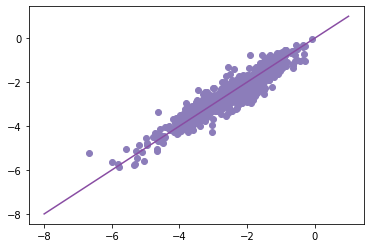

In [54]:
y_pred = lrm.predict(X_test) 
plt.plot(y_test, y_pred, 'o', color=colors[3])

x = np.linspace(-8, 1, 100)
y = x
plt.plot(x, y, color=colors[4])
plt.show()

**모델 성능 평가**

In [55]:
r2 = lrm.score(X_test, y_test)
mse = mean_squared_error(y_test, lrm.predict(X_test))
print('R2 : {} \nMSE : {}'.format(r2, mse))

R2 : 0.887096494268603 
MSE : 0.1056309546962976


VIF를 확인한 결과, 다중 공선성이 있었지만 VIF가 가장 큰 변수를 순차적으로 제거하더라도 모델의 설명력이나 MSE에 큰 영향을 미치지 못하는 것을 확인했으므로 결과 예측의 용이성을 위해 전체 변수를 활용하도록 하였다.

<br>

### 3-3. KNN 모델 적합

In [56]:
X_knn = data.drop(['congestion', 'passenger'], axis=1)
y_knn = data.congestion

X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=0) 

In [57]:
accuracy = []
for k in range(1, 20):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_train, y_train)
    accuracy.append(classifier.score(X_test, y_test))

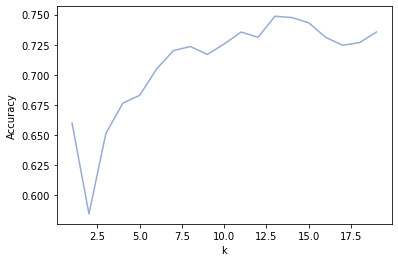

In [58]:
plt.plot(range(1, 20, 1), accuracy, color=colors[2])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

In [59]:
classifier = KNeighborsClassifier(n_neighbors = 13)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

**예측**

In [60]:
y_pred = classifier.predict(X_test)

**모델 성능 평가**

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.78       282
           1       0.67      0.62      0.64       309
           2       0.82      0.81      0.81       324

    accuracy                           0.75       915
   macro avg       0.75      0.75      0.75       915
weighted avg       0.75      0.75      0.75       915



In [62]:
print(classifier.score(X_test, y_test))

0.7486338797814208


<br>

### 3-4. 예측

In [63]:
try: 
  dayweek_num = int(input('★ 우리 언제 만나 (평일/주말) ★ \n\n평일: 0 \n주말: 1 \n\n숫자를 입력해주세요: '))
  dayweek = ['주중', '주말'][dayweek_num]
  subname = mid_subname
  time = int(input('★ 우리 언제 만나 (시간대) ★ \n\n07~09시: 1 \n09~11시: 2 \n11~13시: 3 \n13~15시: 4 \n15~17시: 5 \n17~19시: 6 \n19~21시: 7 \n21~23시: 8\n\n숫자를 입력해주세요: ')) 
  time_str = ['07~09시', '09~11시', '11~13시', '13~15시', '15~17시', '17~19시', '19~21시', '21~23시']
  
  reg_passenger = lrm.predict(X_reg[(X_reg['subname_'+str(mid_subname)] == 1) & (X_reg['dayweek_'+str(dayweek)] == 1) & (X_reg['time_'+str(time)] == 1)].values)
  if reg_passenger[0] > percent[1]: reg_result = '혼잡'
  elif reg_passenger[0] > percent[0]:reg_result = '보통'
  else: reg_result = '여유'

  knn_cong_num = classifier.predict(X_knn[(X_knn['subname_'+str(mid_subname)] == 1) & (X_knn['dayweek_'+str(dayweek)] == 1) & (X_knn['time_'+str(time)] == 1)].values)
  knn_result = ['여유', '보통', '혼잡'][knn_cong_num[0]]
  
  # regression ver.
  print('\n\n우리가 만날 {}역의 {} {}시간대의 예상 혼잡도는 "{}" 입니다'.format(subname, dayweek, time_str[time-1], reg_result))

  # KNN ver.
  print('우리가 만날 {}역의 {} {}시간대의 예상 혼잡도는 "{}" 입니다'.format(subname, dayweek, time_str[time-1], knn_result))
    
except IndexError:
    print("해당 숫자를 입력해주세요")

★ 우리 언제 만나 (평일/주말) ★ 

평일: 0 
주말: 1 

숫자를 입력해주세요: 0
★ 우리 언제 만나 (시간대) ★ 

07~09시: 1 
09~11시: 2 
11~13시: 3 
13~15시: 4 
15~17시: 5 
17~19시: 6 
19~21시: 7 
21~23시: 8

숫자를 입력해주세요: 4


우리가 만날 신설동역의 주중 13~15시시간대의 예상 혼잡도는 "혼잡" 입니다
우리가 만날 신설동역의 주중 13~15시시간대의 예상 혼잡도는 "혼잡" 입니다
